<h3>
Run Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<h3>
Load Optical Flow Data

In [3]:
# Load in the optical flow npz data

flows_0 = np.load('/home/armlab/Documents/soft_manipulation/0layer_trials_alldata_avgpoolby6_2_mags.npz')['flow_data']
print(f"Flow data for 0 layers has shape {flows_0.shape}")

flows_1 = np.load('/home/armlab/Documents/soft_manipulation/1layer_trials_alldata_avgpoolby6_2_mags.npz')['flow_data']
print(f"Flow data for 1 layers has shape {flows_1.shape}")

flows_2 = np.load('/home/armlab/Documents/soft_manipulation/2layer_trials_alldata_avgpoolby6_2_mags.npz')['flow_data']
print(f"Flow data for 2 layers has shape {flows_2.shape}")

Flow data for 0 layers has shape (100, 23, 128, 170)
Flow data for 1 layers has shape (100, 23, 128, 170)
Flow data for 2 layers has shape (100, 23, 128, 170)


In [4]:
# Split the data into training and testing
# 75% training, 25% testing
num_trials_0 = flows_0.shape[0]
num_trials_1 = flows_1.shape[0]
num_trials_2 = flows_2.shape[0]

train_0 = flows_0[:int(0.75*num_trials_0)]
test_0 = flows_0[int(0.75*num_trials_0):]
train_1 = flows_1[:int(0.75*num_trials_1)]
test_1 = flows_1[int(0.75*num_trials_1):]
train_2 = flows_2[:int(0.75*num_trials_2)]
test_2 = flows_2[int(0.75*num_trials_2):]

print(f"Training data for 0 layers has shape {train_0.shape}")
print(f"Testing data for 0 layers has shape {test_0.shape}")
print(f"Training data for 1 layers has shape {train_1.shape}")
print(f"Testing data for 1 layers has shape {test_1.shape}")
print(f"Training data for 2 layers has shape {train_2.shape}")
print(f"Testing data for 2 layers has shape {test_2.shape}")

Training data for 0 layers has shape (75, 23, 128, 170)
Testing data for 0 layers has shape (25, 23, 128, 170)
Training data for 1 layers has shape (75, 23, 128, 170)
Testing data for 1 layers has shape (25, 23, 128, 170)
Training data for 2 layers has shape (75, 23, 128, 170)
Testing data for 2 layers has shape (25, 23, 128, 170)


In [5]:
train_data = np.concatenate((train_0, train_1, train_2), axis=0)
train_data_tensor = torch.tensor(train_data).float().to(device)
# train_data_tensor = train_data_tensor.reshape(225, 2*23, 128, 170)

labels_train = np.empty((train_data.shape[0]))
labels_train[:train_0.shape[0]] = 0
labels_train[train_0.shape[0]:train_0.shape[0]+train_1.shape[0]] = 1
labels_train[train_0.shape[0]+train_1.shape[0]:] = 2
labels_train = torch.tensor(labels_train, dtype=torch.long).to(device)
print(f"Train Labels Shape: {labels_train.shape}")

Train Labels Shape: torch.Size([225])


In [6]:
labels_test = np.empty((test_1.shape[0] + test_0.shape[0] + test_2.shape[0]))
labels_test[0:25] = 0
labels_test[25:50] = 1
labels_test[50:75] = 2
labels_test = torch.tensor(labels_test, dtype=torch.long).to(device)
print(f"Train Labels Shape: {labels_test.shape}")

test_data = np.concatenate((test_0, test_1, test_2), axis=0)
test_data_tensor = torch.tensor(test_data).float().to(device)
# test_data_tensor = test_data_tensor.reshape(75, 23, 128, 170)
print(labels_test)

Train Labels Shape: torch.Size([75])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2], device='cuda:0')


In [7]:
# from torch.utils.data import DataLoader, TensorDataset

# train_dataset = TensorDataset(train_data_tensor, labels_train)
# test_dataset = TensorDataset(test_data_tensor, labels_test)

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

<h3>
Load Force Data

In [8]:
# Load in the optical flow npz data

forces_0 = np.load('/home/armlab/Documents/soft_manipulation/0layer_forces.npz')['force_data_array']
print(f"Flow data for 0 layers has shape {forces_0.shape}")

forces_1 = np.load('/home/armlab/Documents/soft_manipulation/1layer_forces.npz')['force_data_array']
print(f"Flow data for 1 layers has shape {forces_1.shape}")

forces_2 = np.load('/home/armlab/Documents/soft_manipulation/2layer_forces.npz')['force_data_array']
print(f"Flow data for 2 layers has shape {forces_2.shape}")

Flow data for 0 layers has shape (100, 23, 6)
Flow data for 1 layers has shape (100, 23, 6)
Flow data for 2 layers has shape (100, 23, 6)


In [9]:
forces_train_data = np.concatenate((forces_0[0:75], forces_1[0:75], forces_2[0:75]), axis=0)
forces_train_data_tensor = torch.tensor(forces_train_data).float().to(device)

forces_test_data = np.concatenate((forces_0[75:100], forces_1[75:100], forces_2[75:100]), axis=0)
forces_test_data_tensor = torch.tensor(forces_test_data).float().to(device)

print(f"Forces Train data shape: {forces_train_data_tensor.shape}")
print(f"Forces Test data shape: {forces_test_data_tensor.shape}")

Forces Train data shape: torch.Size([225, 23, 6])
Forces Test data shape: torch.Size([75, 23, 6])


<h3>
Make Data Loader

In [10]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_data_tensor, forces_train_data_tensor, labels_train)
test_dataset = TensorDataset(test_data_tensor, forces_test_data_tensor, labels_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

<h3>
Create and Train Model

In [33]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_size):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=(1, 2))  # (N, 16, 64, 85)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=(1, 2))  # (N, 32, 32, 43)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # (N, 64, 16, 22)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # (N, 128, 8, 11)
        self.fc1 = nn.Linear(128 * 8 * 11, 512)  # Latent vector size = 512
        self.fc2 = nn.Linear(512, 128)  # Output size = 256
        self.fc3 = nn.Linear(128, output_size)  # Output size = 256

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten
        z = self.fc1(x)  # Latent vector is dim 512
        x = self.fc2(z)
        x = self.fc3(x)
        return x, z

class ForceFeatureExtractor(nn.Module):
    def __init__(self, input_size, output_size):
        super(ForceFeatureExtractor, self).__init__()
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, output_size)
        # self.fc1 = nn.Linear(input_size, 16)
        # self.fc2 = nn.Linear(16, output_size)
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = self.fc3(x)
        return z

class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, dim_feedforward, num_classes, force_input_size, force_output_size):
        super(TransformerModel, self).__init__()
        self.feature_extractor = CNNFeatureExtractor(d_model)
        self.force_extractor = ForceFeatureExtractor(force_input_size, force_output_size)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 23, d_model + force_output_size))
        encoder_layers = nn.TransformerEncoderLayer(d_model + force_output_size, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc = nn.Linear(d_model + force_output_size, num_classes)
        self.d_model = d_model

    def forward(self, image_data, force_data):
        batch_size, seq_len, _, _, = image_data.shape
        image_data = image_data.view(batch_size * seq_len, 1, 128, 170)
        image_features, _ = self.feature_extractor(image_data)
        image_features = image_features.view(batch_size, seq_len, -1)

        force_data = force_data.view(batch_size * seq_len, -1)
        force_features = self.force_extractor(force_data)
        force_features = force_features.view(batch_size, seq_len, -1)

        combined_features = torch.cat((image_features, force_features), dim=2)
        combined_features += self.pos_encoder[:, :seq_len, :]

        x = self.transformer_encoder(combined_features)
        x = x.mean(dim=1)  # Pooling over the sequence dimension
        x = self.fc(x)
        return F.softmax(x, dim=1), x  # Return both the logits and the feature vector

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(d_model=60, nhead=6, num_encoder_layers=3, dim_feedforward=2048, num_classes=3, force_input_size=6, force_output_size=6).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
num_epochs = 500
loss_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for image_inputs, force_inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(image_inputs.to(device), force_inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping
        optimizer.step()
        running_loss += loss.item()
    
    # Condition to reset the optimizer state (e.g., halfway through training)
    # if epoch == num_epochs // 2:
    if num_epochs % 50 == 0:
        model_state = model.state_dict()
        optimizer = optim.Adam(model.parameters(), lr=0.00005)
        model.load_state_dict(model_state)

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)

print('Finished Training')

/home/armlab/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.063244636607381
Epoch 2, Loss: 0.9366164128337287
Epoch 3, Loss: 0.9139019862740441
Epoch 4, Loss: 0.8913145381792457
Epoch 5, Loss: 0.8840757840502579
Epoch 6, Loss: 0.8864498470736816
Epoch 7, Loss: 0.8804070284936281
Epoch 8, Loss: 0.8720544829832769
Epoch 9, Loss: 0.8661293735546348
Epoch 10, Loss: 0.8496320005011769
Epoch 11, Loss: 0.8488328330284727
Epoch 12, Loss: 0.8437539972035231
Epoch 13, Loss: 0.822766034476525
Epoch 14, Loss: 0.8132725816912356
Epoch 15, Loss: 0.8006037262688696
Epoch 16, Loss: 0.7720041449091076
Epoch 17, Loss: 0.7461888948373036
Epoch 18, Loss: 0.7576537417099539
Epoch 19, Loss: 0.737749471073657
Epoch 20, Loss: 0.7276396128983624
Epoch 21, Loss: 0.7077767152701859
Epoch 22, Loss: 0.694060019159739
Epoch 23, Loss: 0.6802734463615755
Epoch 24, Loss: 0.6934697190217213
Epoch 25, Loss: 0.6996484251148933
Epoch 26, Loss: 0.6590455823240027
Epoch 27, Loss: 0.6783102581986283
Epoch 28, Loss: 0.6746292879096175
Epoch 29, Loss: 0.646496177247140

<h3>
Determine Accuracy

In [34]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for image_inputs, force_inputs, labels in test_loader:
            image_inputs, force_inputs, labels = image_inputs.to(device), force_inputs.to(device), labels.to(device)
            outputs, _ = model(image_inputs, force_inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total * 100

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    
    return avg_loss, accuracy

test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

Test Loss: 0.7655, Test Accuracy: 78.67%


<h3>
Plot Loss Function


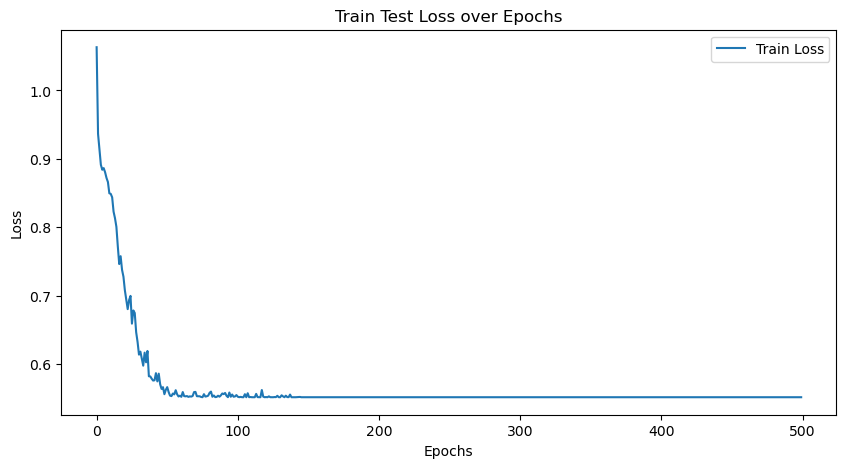

In [35]:
def plot_losses(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train Test Loss over Epochs')
    plt.show()

# Call this function after training
plot_losses(loss_values)


<h3>
Plot T-SNE Feature Space

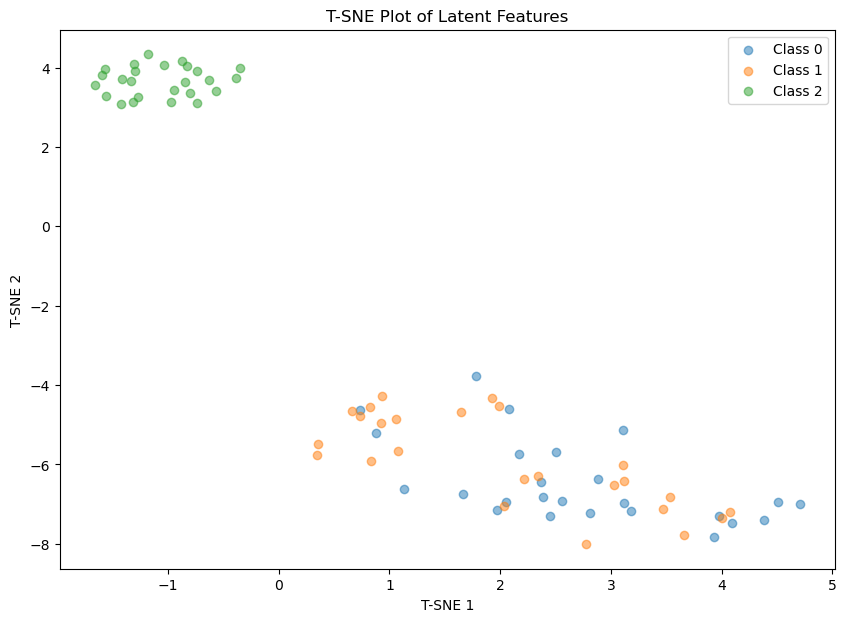

In [36]:
def extract_latent_features(model, data_loader, device):
    model.eval()
    latent_features = []
    labels_list = []

    with torch.no_grad():
        for image_inputs, force_inputs, labels in data_loader:
            image_inputs, force_inputs, labels = image_inputs.to(device), force_inputs.to(device), labels.to(device)
            _, latent = model(image_inputs, force_inputs)
            latent_features.append(latent.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    latent_features = np.concatenate(latent_features)
    labels_list = np.concatenate(labels_list)
    
    return latent_features, labels_list

latent_features, labels_list = extract_latent_features(model, test_loader, device)

# Apply T-SNE and plot
def plot_tsne(latent_features, labels_list, num_classes=3):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(latent_features)

    plt.figure(figsize=(10, 7))
    for class_id in range(num_classes):
        indices = labels_list == class_id
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {class_id}', alpha=0.5)
    
    plt.legend()
    plt.title('T-SNE Plot of Latent Features')
    plt.xlabel('T-SNE 1')
    plt.ylabel('T-SNE 2')
    plt.show()

plot_tsne(latent_features, labels_list)